Título do Projeto: Sistema de Identificação de Sintomas
Integrantes:
- Lucas de Sousa Pereira
- Daniel Cordeiro Mantovani Soares
- Victor de Sousa Veríssimo
- Levi de Lima Pereira Júnior
- João Victor Cosme Melo

## Imports

Datasets:

- Link 1: https://www.kaggle.com/datasets/harivatsaga/disease-prediction
- Link 2: https://drive.google.com/file/d/10f31TignOBFKJ-3mnVHeCphJuPoasmYk/view
- Link 3: https://drive.google.com/file/d/17UhRvLyVuJgznFuZ2MlollPV8RaGndjs/view

In [ ]:
%%capture
!pip install transformers datasets torch
!pip install sacremosesv
!pip install sacremoses
!pip install contractions

import pandas as pd
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments
import requests
from bs4 import BeautifulSoup
import torch
from transformers import BioGptForCausalLM, BioGptTokenizer, Trainer, TrainingArguments
from torch.utils.data import Dataset

# Manipulação de texto
import nltk.corpus
from nltk                             import pos_tag, SnowballStemmer
from nltk.tokenize                    import word_tokenize

from nltk.corpus import wordnet

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Prepraração dos dados
import numpy as np
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.model_selection          import train_test_split

# Modelos de classificação
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Perceptron

# Avaliação
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

import contractions
lemmatizer = nltk.stem.WordNetLemmatizer()
param_stemmer = SnowballStemmer('english')

## Importando os Dados

In [ ]:
""" Tucker, Jay (2024). “SymbiPredict”. Mendeley Data, V1. Disponível em: <https://data.mendeley.com/datasets/dv5z3v2xyd/1>

4961 entradas, 41 doenças distintas, 121 entradas por doenças.
Associa a presença ou a ausência de 132 sintomas a um determinado prognóstico médico.

"""
data_one = pd.read_csv("https://drive.google.com/uc?export=download&id=17UhRvLyVuJgznFuZ2MlollPV8RaGndjs")
data_one

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal Infection
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal Infection
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal Infection
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal Infection
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal Infection
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4956,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Vertigo
4957,0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,Acne
4958,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Urinary Tract Infection
4959,0,1,0,0,0,0,1,0,0,0,...,0,0,1,1,1,1,0,0,0,Psoriasis


In [ ]:
""" Tharmalingam, Laksika (2024). Disease Symptoms and Patient Profile. Kaggle. Disponível em: <https://www.kaggle.com/datasets/uom190346a/disease-symptoms-and-patient-profile-dataset>

349 entradas, 116  distintas, número de entradas por doença varia bastante: desde 23 para asma até apenas 1 para câncer colorretal."
Associa, para cada doença, a presença de sintomas, gênero e idade, níveis de pressão arterial e colesterol.

OBS: O campo disease corresponde a uma hipótese. Nem todas entradas são prognósticos confirmados.
    Por exemplo, 'Muscular Dystrophy' tem apenas uma entrada, mas não é de um prognóstico positivo.
"""
data_two = pd.read_csv("https://drive.google.com/uc?export=download&id=10f31TignOBFKJ-3mnVHeCphJuPoasmYk")
data_two

,Disease,Fever,Cough,Fatigue,Difficulty Breathing,Age,Gender,Blood Pressure,Cholesterol Level,Outcome Variable
0,Influenza,Yes,No,Yes,Yes,19,Female,Low,Normal,Positive
1,Common Cold,No,Yes,Yes,No,25,Female,Normal,Normal,Negative
2,Eczema,No,Yes,Yes,No,25,Female,Normal,Normal,Negative
3,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive
4,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive
...,...,...,...,...,...,...,...,...,...,...
344,Stroke,Yes,No,Yes,No,80,Female,High,High,Positive
345,Stroke,Yes,No,Yes,No,85,Male,High,High,Positive
346,Stroke,Yes,No,Yes,No,85,Male,High,High,Positive
347,Stroke,Yes,No,Yes,No,90,Female,High,High,Positive


In [ ]:
"""  Barman , Niyar (2022). Symptom2Disease. Kaggle. Disponível em: <https://www.kaggle.com/datasets/niyarrbarman/symptom2disease/discussion?sort=undefined>

1200 entradas, 24 doenças distintas, 50 entradas por doença.
Para cada doença, associa uma descrição dos sintomass, em linguagem natural e primeira pessoa.

EX: "Doutor, minha pele está coberta por uma erupção muito desconfortável,
     junto com algumas manchas estranhas de um tom diferente. Minha pele
     também tem algumas espinhas que lembram pequenos nós"
     >>>> INFECÇÃO FÚNGICA

     "Mesmo quando não tenho nada ácido no estômago, sinto constantemente
     um gosto amargo na boca. Freqüentemente tenho um nó na garganta e
     soluços.
     >>>> DOENÇA DO REFLUXO GASTROESOFÁGICO"
"""
data_three = pd.read_csv("https://drive.google.com/uc?export=download&id=1yyD_6vwPY9p-AlHYxJO3JNkbxXYuKrQr")
data_three

,Unnamed: 0,label,text
0,0,Psoriasis,I have been experiencing a skin rash on my arm...
1,1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,2,Psoriasis,I have been experiencing joint pain in my fing...
3,3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,4,Psoriasis,"My nails have small dents or pits in them, and..."
...,...,...,...
1195,295,diabetes,I'm shaking and trembling all over. I've lost ...
1196,296,diabetes,"Particularly in the crevices of my skin, I hav..."
1197,297,diabetes,I regularly experience these intense urges and...
1198,298,diabetes,"I have trouble breathing, especially outside. ..."


## Formatação dos Dados

In [ ]:
# Normalização dos dados do Data Frame One
def clean_label(label):
    if label == 'dimorphic hemmorhoids (piles)':
        label = 'dimorphic hemorrhoids'
    if label == 'bronchial asthma':
        label = 'asthma'
    if label == 'peptic ulcer disease':
        label = 'peptic ulcer'
    return label

data_one = data_one.rename(columns={'prognosis': 'label'})
data_one['label'] = data_one['label'].str.lower().str.strip()
symptom_columns = data_one.columns[:-1]
data_one['symptoms'] = data_one[symptom_columns].apply(
    lambda row: ', '.join([col for col, val in row.items() if val == 1]), axis=1
)
data_one = data_one[['label', 'symptoms']]
data_one['label'] = data_one['label'].apply(clean_label)
data_one

<ipython-input-5-6ec8206b4f51>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_one['label'] = data_one['label'].apply(clean_label)


,label,symptoms
0,fungal infection,"itching, skin_rash, nodal_skin_eruptions, disc..."
1,fungal infection,"skin_rash, nodal_skin_eruptions, dischromic _p..."
2,fungal infection,"itching, nodal_skin_eruptions, dischromic _pat..."
3,fungal infection,"itching, skin_rash, dischromic _patches"
4,fungal infection,"itching, skin_rash, nodal_skin_eruptions"
...,...,...
4956,vertigo,"vomiting, headache, nausea, spinning_movements..."
4957,acne,"skin_rash, pus_filled_pimples, blackheads, scu..."
4958,urinary tract infection,"burning_micturition, bladder_discomfort, foul_..."
4959,psoriasis,"skin_rash, joint_pain, skin_peeling, silver_li..."


In [ ]:
# Normalização dos dados do Data Frame Two
import re

def extrair_sintomas(row):
    symptoms = []
    if row['Fever'] == 'Yes':
        symptoms.append('Fever')
    if row['Cough'] == 'Yes':
        symptoms.append('Cough')
    if row['Fatigue'] == 'Yes':
        symptoms.append('Fatigue')
    if row['Difficulty Breathing'] == 'Yes':
        symptoms.append('Difficulty Breathing')
    if row['Blood Pressure'] == 'Low':
        symptoms.append('Low Blood Pressure')
    if row['Blood Pressure'] == 'High':
        symptoms.append('High Blood Pressure')
    if row['Blood Pressure'] == 'Normal':
        symptoms.append('Normal Blood Pressure')
    if row['Cholesterol Level'] == 'Low':
        symptoms.append('Low Cholesterol Level')
    if row['Cholesterol Level'] == 'High':
        symptoms.append('High Cholesterol Level')
    if row['Cholesterol Level'] == 'Normal':
        symptoms.append('Normal Cholesterol Level')
    return symptoms

def clean_label(label):
    label = re.sub(r'disease', '', label, flags=re.IGNORECASE)
    label = re.sub(r"'s\s", '', label)
    label = re.sub(r'\(.*?\)', '', label)
    label = re.sub(r'\(.*', '', label)
    label = re.sub(r'\.\.\.', '', label)
    label = label.strip()
    return label

def filtrar_doencas_com_5_ou_mais_ocorrencias(df):
    contagem = df['label'].value_counts()
    doencas_frequentes = contagem[contagem >= 5].index
    df_filtrado = df[df['label'].isin(doencas_frequentes)]

    return df_filtrado

data_two = data_two.rename(columns={'Disease': 'label'})
data_two = data_two.loc[data_two['Outcome Variable'] == 'Positive']
data_two['symptoms'] = data_two.apply(extrair_sintomas, axis=1)
data_two['label'] = data_two['label'].apply(clean_label)
data_two['label'] = data_two['label'].str.lower()
data_two = data_two.drop(columns=['Age', 'Gender', 'Outcome Variable', 'Fever', 'Cough', 'Fatigue', 'Difficulty Breathing', 'Blood Pressure', 'Cholesterol Level'])
data_two['symptoms'] = data_two['symptoms'].apply(lambda x: ', '.join(x))
data_two = data_two.sort_values(by='label')
data_two = filtrar_doencas_com_5_ou_mais_ocorrencias(data_two)

# data_two

In [ ]:
# Normalização dos dados do Data Frame Three
def clean_label(label):
  if label == 'chicken pox':
    label = 'chickenpox'
  if label == 'bronchial asthma':
    label = 'asthma'

  label = re.sub(r'disease', '', label, flags=re.IGNORECASE)
  label = re.sub(r"'s\s", '', label)
  label = re.sub(r'\(.*?\)', '', label)
  label = re.sub(r'\(.*', '', label)
  label = re.sub(r'\.\.\.', '', label)
  label = label.strip()

  return label

data_three = data_three.drop('Unnamed: 0', axis=1)
data_three = data_three.rename(columns={'text': 'symptoms'})
data_three['label'] = data_three['label'].str.lower()
data_three['label'] = data_three['label'].str.strip()
data_three['label'] = data_three['label'].apply(clean_label)
data_three

,label,symptoms
0,psoriasis,I have been experiencing a skin rash on my arm...
1,psoriasis,"My skin has been peeling, especially on my kne..."
2,psoriasis,I have been experiencing joint pain in my fing...
3,psoriasis,"There is a silver like dusting on my skin, esp..."
4,psoriasis,"My nails have small dents or pits in them, and..."
...,...,...
1195,diabetes,I'm shaking and trembling all over. I've lost ...
1196,diabetes,"Particularly in the crevices of my skin, I hav..."
1197,diabetes,I regularly experience these intense urges and...
1198,diabetes,"I have trouble breathing, especially outside. ..."


In [ ]:
# Concatenar os quatro DataFrames
df = pd.concat([data_one, data_three], ignore_index=True)
df

,label,symptoms
0,fungal infection,"itching, skin_rash, nodal_skin_eruptions, disc..."
1,fungal infection,"skin_rash, nodal_skin_eruptions, dischromic _p..."
2,fungal infection,"itching, nodal_skin_eruptions, dischromic _pat..."
3,fungal infection,"itching, skin_rash, dischromic _patches"
4,fungal infection,"itching, skin_rash, nodal_skin_eruptions"
...,...,...
6156,diabetes,I'm shaking and trembling all over. I've lost ...
6157,diabetes,"Particularly in the crevices of my skin, I hav..."
6158,diabetes,I regularly experience these intense urges and...
6159,diabetes,"I have trouble breathing, especially outside. ..."


## Pré-Processamento

In [ ]:
def remove_palavras_pequenas_grandes(tokens):
  return [token for token in tokens if len(token) > 2 and len(token) < 16]

def remove_stopwords(tokens):
  liststopwords = nltk.corpus.stopwords.words('english')
  return [token for token in tokens if token not in liststopwords]

def stemming(tokens, stemmer):
  return [stemmer.stem(token) for token in tokens]

def corrigir_documento(document):
  return contractions.fix()

def get_wordnet_pos(treebank_tag):
  if treebank_tag.startswith('J'):
    return wordnet.ADJ
  elif treebank_tag.startswith('V'):
    return wordnet.VERB
  elif treebank_tag.startswith('N'):
    return wordnet.NOUN
  elif treebank_tag.startswith('R'):
    return wordnet.ADV
  else:
    return None

def lemmatize(tokens):
  lemmatized_tokens = []
  pos_tagged = pos_tag(tokens)
  for token, tag in pos_tagged:
    wordnet_pos = get_wordnet_pos(tag) or wordnet.NOUN
    lemmatized_tokens.append(lemmatizer.lemmatize(token, pos=wordnet_pos))

  return lemmatized_tokens

In [ ]:
def process_corpus(corpus):
  corpus_processed = []
  for document in corpus:
    tokens = word_tokenize(document)
    tokens = remove_palavras_pequenas_grandes(tokens)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize(tokens)
    tokens = stemming(tokens, param_stemmer)
    corpus_processed.append(" ".join(tokens))
  return corpus_processed

corpus = df['symptoms'].tolist()
corpus_processed = process_corpus(corpus)

## Treinamento

In [ ]:
x_treino, x_teste, y_treino, y_teste = train_test_split(corpus_processed, df['label'], test_size=0.2, shuffle=True)

vetorizador = TfidfVectorizer(max_df=0.95, min_df=1, ngram_range=(1,3), max_features=None)

In [ ]:
x_treino_vetorizado = vetorizador.fit_transform(x_treino)
x_teste_vetorizado = vetorizador.transform(x_teste)

In [ ]:
modelo_RegressaoLogistica = LogisticRegression()
modelo_RegressaoLogistica.fit(x_treino_vetorizado, y_treino)
predicao_RegressaoLogistica = modelo_RegressaoLogistica.predict(x_teste_vetorizado)

## Precisão/Acurácia

In [ ]:
accuracy = accuracy_score(y_teste, predicao_RegressaoLogistica)
print(f'Acurácia: {accuracy:.2f}')

Acurácia: 0.99


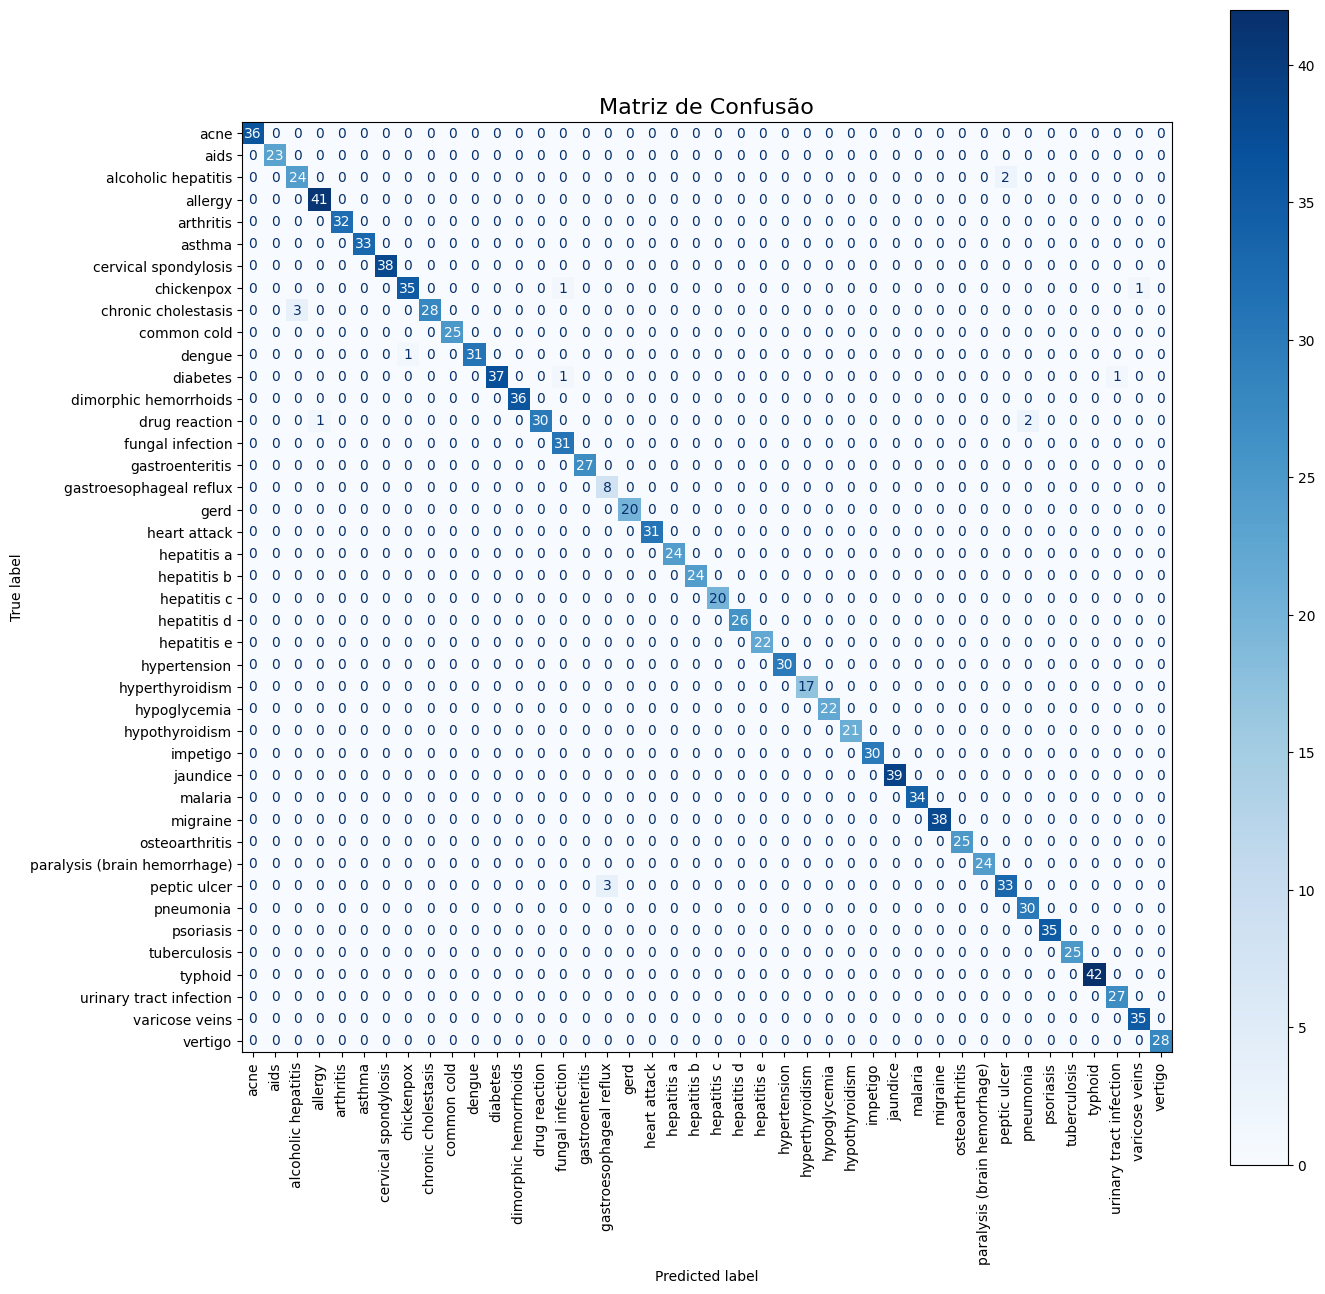

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, classification_report
import matplotlib.pyplot as plt

# Previsão do modelo
predicao_RegressaoLogistica = modelo_RegressaoLogistica.predict(x_teste_vetorizado)

# Geração da matriz de confusão
matriz_confusao = confusion_matrix(y_teste, predicao_RegressaoLogistica)

# Obter os rótulos únicos das variáveis reais e preditas
labels = sorted(set(y_teste) | set(predicao_RegressaoLogistica))  # Combina rótulos de y_teste e predições

# Ajuste o tamanho da figura para lidar com muitas classes
fig, ax = plt.subplots(figsize=(15, 15))  # Ajuste `figsize` conforme necessário

# Exibição da matriz de confusão com os rótulos corretos
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, ax=ax)  # Use `ax=ax` para desenhar no subplot criado

# Ajustes de rótulos e título
plt.xticks(rotation=90, fontsize=10)  # Ajusta a rotação e o tamanho da fonte dos rótulos
plt.yticks(fontsize=10)  # Ajusta o tamanho da fonte no eixo y
plt.title("Matriz de Confusão", fontsize=16)  # Define um título maior para melhor visualização
plt.show()

In [ ]:
## Geração do relatório de precisão, revocação e F1-Score

relatorio = classification_report(y_teste, predicao_RegressaoLogistica, target_names=labels)
print(relatorio)

                              precision    recall  f1-score   support

                        acne       1.00      1.00      1.00        36
                        aids       1.00      1.00      1.00        23
         alcoholic hepatitis       0.89      0.92      0.91        26
                     allergy       0.98      1.00      0.99        41
                   arthritis       1.00      1.00      1.00        32
                      asthma       1.00      1.00      1.00        33
        cervical spondylosis       1.00      1.00      1.00        38
                  chickenpox       0.97      0.95      0.96        37
         chronic cholestasis       1.00      0.90      0.95        31
                 common cold       1.00      1.00      1.00        25
                      dengue       1.00      0.97      0.98        32
                    diabetes       1.00      0.95      0.97        39
       dimorphic hemorrhoids       1.00      1.00      1.00        36
               drug

## Exemplos

In [ ]:
import numpy as np

def processa_entrada(vetorizador, classificador, entrada, top_n):
  resultado = ""

  processed_input = entrada.strip().lower().split()
  processed_input = process_corpus(processed_input)
  processed_input = [word for word in processed_input if word != '']
  processed_input = ' '.join(processed_input)

  if (processed_input != ""):
    corpus_processados = process_corpus([processed_input])
    predicao_y = vetorizador.transform(corpus_processados)

    probas = classificador.predict_proba(predicao_y)[0]

    classes = classificador.classes_

    class_proba = list(zip(classes, probas))

    resultado = sorted(class_proba, key=lambda x: x[1], reverse=True)[:top_n]

  return resultado

In [ ]:
# Exemplo de uso - DENGUE
# febre alta, erupções cutâneas e dores musculares e articulares, sangramento intenso e choque hemorrágico
input_text = "high fever, skin rashes and muscle and joint pain, heavy bleeding and hemorrhagic shock"

resultadoRegressaoLogistica = processa_entrada(vetorizador, modelo_RegressaoLogistica, input_text, 4)

print("Top 4 resultados e probabilidades:")
for label, prob in resultadoRegressaoLogistica:
    print(f"Classe: {label}, Probabilidade: {(prob*100):.4f}%")

Top 4 resultados e probabilidades:
Classe: psoriasis, Probabilidade: 8.5597%
Classe: dengue, Probabilidade: 8.2660%
Classe: impetigo, Probabilidade: 6.9573%
Classe: malaria, Probabilidade: 4.5272%


In [ ]:
# Exemplo de uso - DIABETES
# sede ou micção excessiva, fadiga, perda de peso ou visão turva.
input_text = '''
  I've been feeling constantly thirsty, hungry more often, and tired for no clear reason. I'm urinating a lot, especially at night, and my vision gets blurry at times.
  I've noticed small cuts take longer to heal, and I've lost some weight without trying. Occasionally, I feel tingling or numbness in my hands and feet.
'''
resultadoRegressaoLogistica = processa_entrada(vetorizador, modelo_RegressaoLogistica, input_text, 4)

# Mostrar os resultados
print("Top 4 resultados e probabilidades:")
for label, prob in resultadoRegressaoLogistica:
    print(f"Classe: {label}, Probabilidade: {(prob*100):.4f}%")

Top 4 resultados e probabilidades:
Classe: diabetes, Probabilidade: 12.9427%
Classe: urinary tract infection, Probabilidade: 6.1604%
Classe: peptic ulcer, Probabilidade: 5.4550%
Classe: allergy, Probabilidade: 4.7266%


In [ ]:
# Exemplo de uso - VARICOSE VEINS
# os vasos sanguíneos nas minhas pernas são bastante visíveis, cólicas, sangue
input_text = "blood vessels on my legs are quite visible, cramps, blood"
resultadoRegressaoLogistica = processa_entrada(vetorizador, modelo_RegressaoLogistica, input_text, 4)

# Mostrar os resultados
print("Top 4 resultados e probabilidades:")
for label, prob in resultadoRegressaoLogistica:
    print(f"Classe: {label}, Probabilidade: {(prob*100):.4f}%")

Top 4 resultados e probabilidades:
Classe: varicose veins, Probabilidade: 23.1708%
Classe: urinary tract infection, Probabilidade: 6.1752%
Classe: peptic ulcer, Probabilidade: 3.8268%
Classe: drug reaction, Probabilidade: 3.4266%


In [ ]:
# Exemplo de uso - PNEUMONIA
# febre, tosse e dor no peito, falta de ar
input_text = '''
  I've been having trouble breathing, with a cough that produces mucus. I also feel chest pain, especially when I breathe deeply or cough. I’ve had a fever, chills, and I’ve been
  feeling unusually tired and weak. Sometimes, I get short of breath even when doing light activities.
'''
resultadoRegressaoLogistica = processa_entrada(vetorizador, modelo_RegressaoLogistica, input_text, 4)

# Mostrar os resultados
print("Top 4 resultados e probabilidades:")
for label, prob in resultadoRegressaoLogistica:
    print(f"Classe: {label}, Probabilidade: {(prob*100):.4f}%")

Top 4 resultados e probabilidades:
Classe: asthma, Probabilidade: 15.7969%
Classe: pneumonia, Probabilidade: 9.6155%
Classe: allergy, Probabilidade: 8.4205%
Classe: common cold, Probabilidade: 4.7741%


In [ ]:
# Função para formatar e exibir o resultado
def formatar_saida(resultados, numero_de_resultados=4):
    print("\nOlá! Com base nos sintomas que você descreveu, aqui estão algumas doenças que podem estar relacionadas:")
    print(f"Top {numero_de_resultados} resultados e probabilidades:\n")
    for i, (label, prob) in enumerate(resultados):
        print(f"{i + 1}. Possível doença: {label}, Probabilidade: {(prob*100):.2f}%")

    print("\nImportante: Isso é apenas uma estimativa e não substitui uma consulta com um profissional de saúde.")
    print("Se você estiver preocupado com seus sintomas, recomendamos que procure orientação médica.")

def main():
    input_text = input("Por favor, insira uma descrição dos seus sintomas (ex: sede excessiva, fadiga, perda de peso): ")

    resultadoRegressaoLogistica = processa_entrada(vetorizador, modelo_RegressaoLogistica, input_text, 4)

    formatar_saida(resultadoRegressaoLogistica)

# Executar o programa
if __name__ == "__main__":
    main()